In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from multiprocessing import Pool
from glob import glob
from os.path import join
from pyproj import Proj
from sklearn.mixture import GaussianMixture
def load_storm_data_file(data_file, variable_names):
    try:
        run_filename = data_file.split("/")[-1][:-3].split("_")
        member = int(run_filename[6])
        run_date = run_filename[4]
        ds = xr.open_dataset(data_file)
        patch_arr = []
        all_vars = list(ds.variables.keys())
        meta_cols = ["center_lon", "center_lat", "valid_dates", "run_dates", "members"]
        return_dict = {"data_file": data_file, "meta": None, "data_patches": None}
        if np.all(np.in1d(variable_names, all_vars)):
            meta_dict = {}
            meta_dict["center_lon"] = ds["longitude"][:, 32, 32].values
            meta_dict["center_lat"] = ds["latitude"][:, 32, 32].values
            meta_dict["valid_dates"] = pd.DatetimeIndex(ds["valid_date"].values)
            meta_dict["run_dates"] = np.tile(run_date, meta_dict["valid_dates"].size)
            meta_dict["members"] = np.tile(member, meta_dict["valid_dates"].size)
            return_dict["meta"] = pd.DataFrame(meta_dict, columns=meta_cols)
            for variable in variable_names:
                patch_arr.append(ds[variable][:, 16:-16, 16:-16].values.astype(np.float32))
            return_dict["data_patches"] = np.stack(patch_arr, axis=-1)
            print(data_file, return_dict["meta"].size)
        ds.close()
        del patch_arr[:]
        del patch_arr
        del ds
        return return_dict
    except Exception as e:
        print(traceback.format_exc())
        raise e
        
def load_storm_patch_data(data_path, variable_names, n_procs):
    """


    Args:
        data_path:
        variable_names:
        n_procs:

    Returns:

    """
    data_patches = []
    data_meta = []

    data_files = sorted(glob(join(data_path, "*.nc")))
    pool = Pool(n_procs, maxtasksperchild=1)
    file_check = data_files[:]

    def combine_storm_data_files(return_obj):
        f_index = file_check.index(return_obj["data_file"])
        if return_obj["meta"] is not None:
            data_patches[f_index] = return_obj["data_patches"]
            data_meta[f_index] = return_obj["meta"]
        else:
            file_check.pop(f_index)
            data_patches.pop(f_index)
            data_meta.pop(f_index)

    for data_file in data_files:
        data_patches.append(None)
        data_meta.append(None)
        pool.apply_async(load_storm_data_file, (data_file, variable_names), callback=combine_storm_data_files)
    pool.close()
    pool.join()
    del pool
    all_data = np.vstack(data_patches)
    all_meta = pd.concat(data_meta, ignore_index=True)
    return all_data, all_meta

In [2]:
hail_data = load_storm_patch_data("/glade/work/dgagne/ncar_ens_storm_patches/", 
                      ["thompson_max_hail_k1_surface_current"], 4)

/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_04.nc 650
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_03.nc 760
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_01.nc 640
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_02.nc 950
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_05.nc 605
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_07.nc 760
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_08.nc 805
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_06.nc 835
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_10.nc 700
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050400_mem_01.nc 460
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050400_mem_02.nc 325
/glade/wor

In [3]:
hail_sizes = hail_data[0].ravel() * 1000
hail_sizes = hail_sizes[hail_sizes > 0]

In [4]:
max_hail = hail_data[0].max(axis=-1).max(axis=-1).max(axis=-1) * 1000

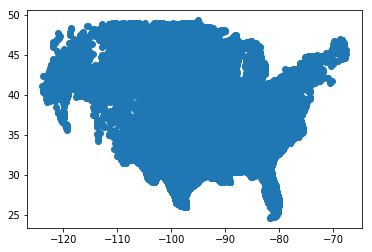

In [8]:
plt.scatter(hail_data[1]["center_lon"], hail_data[1]["center_lat"])

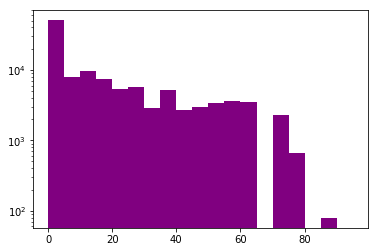

In [74]:
plt.hist(max_hail, bins=np.arange(0, 100, 5), color='purple', density=False)
plt.gca().set_yscale("log")

(array([0.00832816, 0.30509493, 0.55532365, 0.70495479, 0.7845311 ,
        0.84807742, 0.87291112, 0.91436873, 0.93365833, 0.95258642,
        0.97046445, 0.98599488, 0.99573925, 0.99573925, 0.99936527,
        0.99995543, 0.99995543, 1.        , 1.        ]),
 array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80,
        85, 90, 95]),
 <a list of 19 Patch objects>)

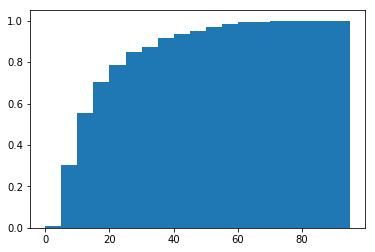

In [25]:
plt.hist(hail_sizes, bins=np.arange(0, 100, 5), density=True, cumulative=True)

In [5]:
hail_reports = pd.read_csv("../2016_hail.csv")

In [6]:
proj_params = dict(
            proj="lcc",
            a=6370000,
            b=6370000,
            lat_0=38.33643,
            lon_0=-101.,
            lat_1=32.0,
            lat_2=46.0,
            units="m")
us_proj = Proj(projparams=proj_params)

In [7]:
hail_report_x, hail_report_y = us_proj(hail_reports["slon"].values, hail_reports["slat"].values)

In [8]:
max_hail_x, max_hail_y = us_proj(hail_data[1]["center_lon"].values, hail_data[1]["center_lat"].values)

In [9]:
model_valid_dates = pd.DatetimeIndex(hail_data[1]["valid_dates"])
report_valid_dates = pd.DatetimeIndex(hail_reports["date"] + "T" + hail_reports["time"]) + pd.Timedelta(hours=6)
distances = np.arange(20000, 220000, 20000)
hail_ct = np.zeros((distances.size, 4), dtype=int)
for d, dist in enumerate(distances):
    for i in range(max_hail.size):
        if i % 10000 == 0:
            print(dist, i, hail_ct.sum(axis=0))
        time_diff = (np.abs(model_valid_dates[i] - report_valid_dates) < pd.Timedelta(hours=6))
        if np.count_nonzero(time_diff) == 0:
            if max_hail[i] >= 25:
                hail_ct[d, 1] += 1
            else:
                hail_ct[d, 3] += 1
            continue
        distance_diff = np.sqrt((max_hail_x[i] - hail_report_x[time_diff]) ** 2 + 
                                (max_hail_y[i] - hail_report_y[time_diff]) ** 2) < dist
        if np.count_nonzero(distance_diff) == 0:
            if max_hail[i] >= 25:
                hail_ct[d, 1] += 1
            else:
                hail_ct[d, 3] += 1
            continue
        max_hail_report_size = hail_reports.loc[time_diff, "mag"].loc[distance_diff].max() * 25.4
        if max_hail_report_size >= 25:
            if max_hail[i] > 25:
                hail_ct[d, 0] += 1
            else:
                hail_ct[d, 2] += 1
        

20000 0 [0 0 0 0]
20000 10000 [ 238 2849  368 6429]
20000 20000 [  715  5402   827 12758]
20000 30000 [  931  8272  1006 19381]
20000 40000 [ 1114 10746  1067 26625]
20000 50000 [ 1365 13708  1236 33200]
20000 60000 [ 1530 16428  1382 40093]
20000 70000 [ 1740 19481  1543 46584]
20000 80000 [ 1878 21991  1722 53669]
20000 90000 [ 2040 24609  1868 60656]
20000 100000 [ 2145 28126  1970 66839]
20000 110000 [ 2165 30159  2002 74739]
40000 0 [ 2168 30626  2009 78480]
40000 10000 [ 2722 33134  2952 84234]
40000 20000 [ 3777 35084  4031 89835]
40000 30000 [ 4229 37657  4495 96071]
40000 40000 [  4661  39874   4709 103130]
40000 50000 [  5265  42467   5196 109377]
40000 60000 [  5717  44850   5639 115886]
40000 70000 [  6264  47497   6118 121926]
40000 80000 [  6650  49720   6606 128627]
40000 90000 [  7090  52024   7006 135243]
40000 100000 [  7417  55232   7342 141058]
40000 110000 [  7482  57208   7484 148825]
60000 0 [  7498  57655   7517 152522]
60000 10000 [  8375  59826   9021 157612]


In [21]:
hail_ct_df = pd.DataFrame(hail_ct, index=(distances / 1000).astype(int), columns=["TP", "FP", "FN", "TN"])
hail_ct_df.to_csv("thompson_hail_ct_distance.csv", index_label="Distance")

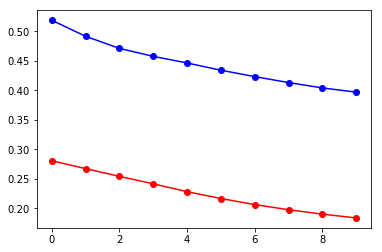

In [79]:
plt.plot(hail_ct[:, 0] / (hail_ct[:, 0] + hail_ct[:, 2]), 'bo-')
plt.plot(hail_ct[:, 1] / (hail_ct[:, 3] + hail_ct[:, 1]), 'ro-')

In [12]:
ct_dists = np.array([ContingencyTable(*hail_ct[i]) for i in range(hail_ct.shape[0])])

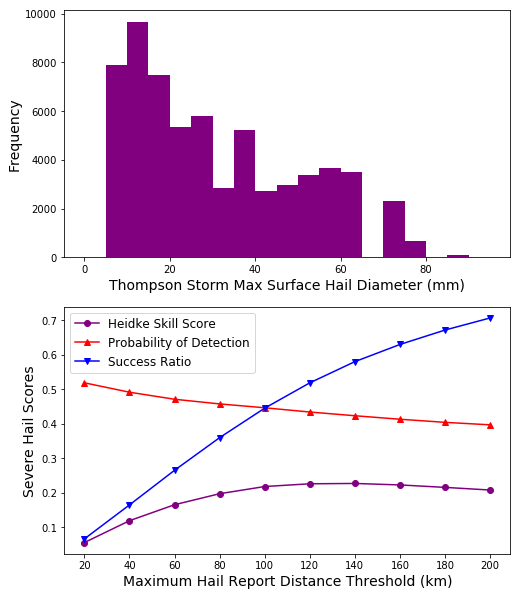

In [18]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
plt.hist(max_hail[max_hail > 0], bins=np.arange(0, 100, 5), color='purple', density=False)
plt.xlabel("Thompson Storm Max Surface Hail Diameter (mm)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.subplot(2, 1, 2)
plt.plot(distances / 1000, [ct_dists[i].hss() for i in range(ct_dists.size)], marker='o', color='purple', label="Heidke Skill Score")
plt.plot(distances / 1000, [ct_dists[i].pod() for i in range(ct_dists.size)], marker='^', color='r', label="Probability of Detection")
plt.plot(distances / 1000, [1-ct_dists[i].far() for i in range(ct_dists.size)], marker='v', color='blue', label="Success Ratio")
plt.legend(fontsize=12)
plt.xticks(np.arange(20, 220, 20))
plt.xlabel("Maximum Hail Report Distance Threshold (km)", fontsize=14)
plt.ylabel("Severe Hail Scores", fontsize=14)
plt.savefig("thompson_verif.pdf", bbox_inches="tight")

In [11]:
class ContingencyTable(object):
    """
    Initializes a binary contingency table and generates many skill scores.

    Args:
        a: true positives
        b: false positives
        c: false negatives
        d: true negatives

    Attributes:
        table (numpy.ndarray): contingency table
        N: total number of items in table

    """
    def __init__(self, a, b, c, d):
        self.table = np.array([[a, b], [c, d]], dtype=float)
        self.N = self.table.sum()

    def update(self, a, b, c, d):
        """
        Update contingency table with new values without creating a new object.
        """
        self.table.ravel()[:] = [a, b, c, d]
        self.N = self.table.sum()

    def __add__(self, other):
        """
        Add two contingency tables together and return a combined one.

        Args:
            other: Another contingency table

        Returns:
            Sum of contingency tables
        """
        sum_ct = ContingencyTable(*(self.table + other.table).tolist())
        return sum_ct

    def pod(self):
        """
        Probability of Detection (POD) or Hit Rate.
        Formula:  a/(a+c)
        """
        return self.table[0, 0] / (self.table[0, 0] + self.table[1, 0])

    def foh(self):
        """
        Frequency of Hits (FOH) or Success Ratio.
        Formula:  a/(a+b)
        """
        return self.table[0, 0] / (self.table[0, 0] + self.table[0, 1])

    def far(self):
        """
        False Alarm Ratio (FAR).
        Formula:  b/(a+b)
        """
        return self.table[0, 1] / (self.table[0, 0] + self.table[0, 1])

    def pofd(self):
        """
        Probability of False Detection (POFD).
        b/(b+d)
        """
        return self.table[0, 1] / (self.table[0, 1] + self.table[1, 1])

    def fom(self):
        """
        Frequency of Misses (FOM).
        Formula:  c/(a+c)."""
        return self.table[1, 0] / (self.table[0, 0] + self.table[1, 0])

    def dfr(self):
        """Returns Detection Failure Ratio (DFR).
           Formula:  c/(c+d)"""
        return self.table[1, 0] / (self.table[1, 0] + self.table[1, 1])

    def pon(self):
        """Returns Probability of Null (PON).
           Formula:  d/(b+d)"""
        return self.table[1, 1] / (self.table[0, 1] + self.table[1, 1])

    def focn(self):
        """Returns Frequency of Correct Null (FOCN).
           Formula:  d/(c+d)"""
        return self.table[1, 1] / (self.table[1, 0] + self.table[1, 1])

    def bias(self):
        """
        Frequency Bias.
        Formula:  (a+b)/(a+c)"""
        return (self.table[0, 0] + self.table[0, 1]) / (self.table[0, 0] + self.table[1, 0])

    def accuracy(self):
        """Finley's measure, fraction correct, accuracy (a+d)/N"""
        return (self.table[0, 0] + self.table[1, 1]) / self.N

    def csi(self):
        """Gilbert's Score or Threat Score or Critical Success Index a/(a+b+c)"""
        return self.table[0, 0] / (self.table[0, 0] + self.table[0, 1] + self.table[1, 0])

    def ets(self):
        """Equitable Threat Score, Gilbert Skill Score, v, (a - R)/(a + b + c - R), R=(a+b)(a+c)/N"""
        r = (self.table[0, 0] + self.table[0, 1]) * (self.table[0, 0] + self.table[1, 0]) / self.N
        return (self.table[0, 0] - r) / (self.table[0, 0] + self.table[0, 1] + self.table[1, 0] - r)

    def hss(self):
        """Doolittle (Heidke) Skill Score.  2(ad-bc)/((a+b)(b+d) + (a+c)(c+d))"""
        return 2 * (self.table[0, 0] * self.table[1, 1] - self.table[0, 1] * self.table[1, 0]) / (
            (self.table[0, 0] + self.table[0, 1]) * (self.table[0, 1] + self.table[1, 1]) +
            (self.table[0, 0] + self.table[1, 0]) * (self.table[1, 0] + self.table[1, 1]))

    def pss(self):
        """Peirce (Hansen-Kuipers, True) Skill Score (ad - bc)/((a+c)(b+d))"""
        return (self.table[0, 0] * self.table[1, 1] - self.table[0, 1] * self.table[1, 0]) / \
               ((self.table[0, 0] + self.table[1, 0]) * (self.table[0, 1] + self.table[1, 1]))

    def css(self):
        """Clayton Skill Score (ad - bc)/((a+b)(c+d))"""
        return (self.table[0, 0] * self.table[1, 1] - self.table[0, 1] * self.table[1, 0]) / \
               ((self.table[0, 0] + self.table[0, 1]) * (self.table[1, 0] + self.table[1, 1]))

    def __str__(self):
        table_string = '\tEvent\n\tYes\tNo\nYes\t%d\t%d\nNo\t%d\t%d\n' % (
            self.table[0, 0], self.table[0, 1], self.table[1, 0], self.table[1, 1])
        return table_string

In [48]:
ct = ContingencyTable(*hail_ct.sum(axis=0))

In [49]:
print(ct)

	Event
	Yes	No
Yes	14158	17621
No	17545	59554



In [56]:
ct.csi()

0.2870407915010948

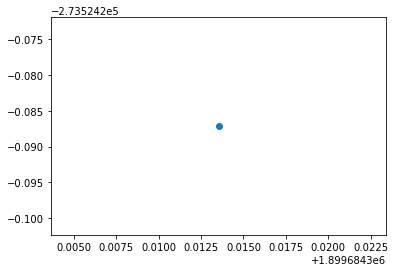

In [28]:
plt.scatter(max_hail_x[0], max_hail_y[0])

(array([2316.,  630.,  241.,  261.,  110.,  138.,  286.,  424., 1311.,
        3687.]),
 array([ 0. ,  2.3,  4.6,  6.9,  9.2, 11.5, 13.8, 16.1, 18.4, 20.7, 23. ]),
 <a list of 10 Patch objects>)

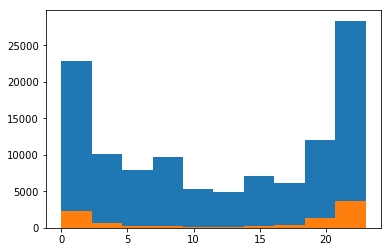

In [39]:
plt.hist(model_valid_dates.hour)
plt.hist(report_valid_dates.hour)

(array([ 287.,  138.,  121.,  271.,  232.,  795., 3200., 2312., 1285.,
         763.]),
 array([ 0. ,  2.3,  4.6,  6.9,  9.2, 11.5, 13.8, 16.1, 18.4, 20.7, 23. ]),
 <a list of 10 Patch objects>)

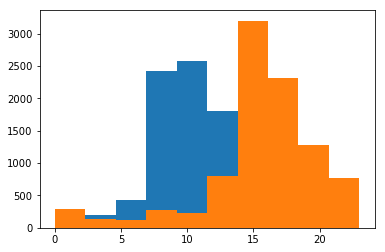

In [35]:
plt.hist(report_valid_dates.hour)
plt.hist(raw_report_valid_dates.hour)

In [34]:
raw_report_valid_dates = pd.DatetimeIndex(hail_reports["date"] + "T" + hail_reports["time"])

DatetimeIndex(['2016-01-08 22:48:00', '2016-01-08 23:57:00',
               '2016-01-09 00:00:00', '2016-01-09 00:00:00',
               '2016-01-09 00:00:00', '2016-01-09 00:03:00',
               '2016-01-09 00:27:00', '2016-01-09 00:32:00',
               '2016-01-09 00:55:00', '2016-01-09 01:00:00',
               ...
               '2016-12-28 21:38:00', '2016-12-28 21:40:00',
               '2016-12-28 21:50:00', '2016-12-28 22:07:00',
               '2016-12-28 22:22:00', '2016-12-28 22:47:00',
               '2016-12-28 22:52:00', '2016-12-28 23:17:00',
               '2016-12-28 23:25:00', '2016-12-28 23:39:00'],
              dtype='datetime64[ns]', length=9404, freq=None)

In [87]:
gmm = GaussianMixture(n_components=5)
gmm.fit(hail_reports[["slon", "slat"]])

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=5, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [101]:
lats = np.arange(-120, -60, 0.5)
lons = np.arange(20, 50, 0.5)
lon_grid, lat_grid = np.meshgrid(lons, lats)
lon_lat = np.vstack((lat_grid.ravel(), lon_grid.ravel())).T

In [94]:
gmm_clusters = gmm.predict_proba(lon_lat)

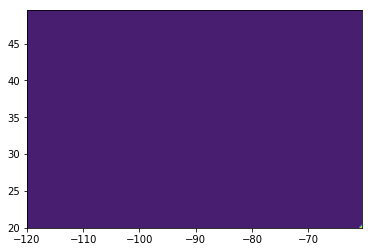

In [102]:
plt.contourf(lat_grid, lon_grid, gmm_clusters[:, 4].reshape(lon_grid.shape))